# Imports

In [1]:
import itertools
import math
import pandas as pd
import json
import os
import glob

from tqdm import tqdm
import seaborn as sns


import screed
import sklearn

%matplotlib inline

# Get ids of "good" reads to use for classification

## Subset to only reads from complete protein sequences -- *will not change with input species*

could maybe write these ids to file

In [1]:
# Quest for Orthologs data
qfo_2019 = '/home/olga/data_sm/immune-evolution/databases/quest-for-orthologs/2019'
qfo_eukaryota = f'{qfo_2019}/Eukaryota'


In [3]:
busco_mammalia_uniprot_protein_starts_with_m = []

# Use only the busco mammalia proteins
with screed.open(f'{qfo_eukaryota}/UP000005640_9606__busco_mammlia_odbv10.fasta') as records:
    for record in records:
        if record['sequence'].startswith("M"):
            busco_mammalia_uniprot_protein_starts_with_m.append(record['name'].split()[0].split('|')[1])
print('busco_mammalia_uniprot_protein_starts_with_m', len(busco_mammalia_uniprot_protein_starts_with_m))


uniprot_dna_starts_with_atg = []
with screed.open(f'{qfo_eukaryota}/UP000005640_9606_DNA.fasta') as records:
    for record in records:
        if record['sequence'].startswith("ATG"):
            uniprot_dna_starts_with_atg.append(record['name'].split()[0].split('|')[1])
print('uniprot_dna_starts_with_atg', len(uniprot_dna_starts_with_atg))

busco_mammalia_uniprot_protein_starts_with_m 8904
uniprot_dna_starts_with_atg 20336


In [4]:
busco_mammalia_startswith_m__and__dna_startswith_atg = set(busco_mammalia_uniprot_protein_starts_with_m).intersection(uniprot_dna_starts_with_atg)
len(busco_mammalia_startswith_m__and__dna_startswith_atg)

8833

## Read gold standard reading frame file

In [5]:
parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/true_reading_frames.parquet'

true_coding_frame = pd.read_parquet(parquet)
# Create just a series (single column) from this
true_coding_frame = true_coding_frame['is_coding']
true_coding_frame.head()

read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1      True
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=2     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=3     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-1    False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-2    False
Name: is_coding, dtype: bool

# Read coding score csvs

## Add read_id_frame and is_coding for computing metrics

In [6]:
def add_read_id_frame_and_is_coding(df):
    df['read_id_frame'] = df.read_id.astype(str) + '__frame=' + df.translation_frame.astype(str)
    df['is_coding'] = df['category'] == "Coding"
    return df

## Get human busco mammalia reads

In [7]:
human_busco_mammalia = pd.read_csv('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/busco_mammalia_human_uniprot_ids.csv')
print(human_busco_mammalia.shape)
human_busco_mammalia.head()

(22539, 3)


,source__uniprot_id,source__id_type,source__db_id
0,P61981,OrthoDB,1176818at2759
1,P27348,OrthoDB,1176818at2759
2,P30443,OrthoDB,1390181at2759
3,Q96QU6,OrthoDB,1156861at2759
4,P10321,OrthoDB,1390181at2759


## Function to read coding scores consistently

In [8]:
!hostname

lrrr


In [9]:
def read_translate_csvs(globber, species=None, 
                        human_busco_mammalia=human_busco_mammalia, 
                        uniprot_dna_starts_with_atg=uniprot_dna_starts_with_atg, 
                        true_coding_frame=true_coding_frame):
    dfs = []
    
    for filename in tqdm(glob.glob(globber)):
        dirname = os.path.dirname(filename)
        parent_dir = os.path.basename(dirname)
        molecule_, ksize_ = parent_dir.split('_')
        molecule = molecule_.split('-')[1]
        ksize = int(ksize_.split('-')[1])
        
        df = pd.read_csv(filename)
        df['alphabet'] = molecule
        df['ksize'] = ksize
        df['species'] = species 
        df = add_read_id_frame_and_is_coding(df)
        
        # Get only reads generated from busco mammalia data
        df['protein_id'] = df['read_id'].map(lambda x: x.split('/')[1].split(';')[0])
        df['uniprot_id'] = df['protein_id'].str.split('|').str[1]
        df = df.query('uniprot_id in @human_busco_mammalia.source__uniprot_id')
        
        # Get only reads from transcripts starting with ATG and no Ns, and only busco mammalia
        df = df.query('uniprot_id in @busco_mammalia_startswith_m__and__dna_startswith_atg')
        
        # Only use reads and frames in the gold standard data
        df = df.query('read_id_frame in @true_coding_frame.index')
        
        # Set the read id and frame as the row names
        df = df.set_index('read_id_frame')

        dfs.append(df)
    concatenated = pd.concat(dfs, ignore_index=False)
    concatenated = concatenated.sort_index()
    return concatenated

## Read Busco mammalia coding scores

In [ ]:
%%time
pipeline_base_dir = "/home/olga/data_sm/immune-evolution/pipeline-results/human-simulated/"
dfs = []
for subfolder in glob.glob(f"{pipeline_base_dir}/*"):
    basename = os.path.basename(subfolder)
    print(basename)
    species = basename.split('--')[-1]
    print(species)
    df = read_translate_csvs(
        f'{subfolder}/translate/*/*.csv', 
        species= species,
        human_busco_mammalia=human_busco_mammalia, 
        uniprot_dna_starts_with_atg=uniprot_dna_starts_with_atg, 
        true_coding_frame=true_coding_frame
    )
    dfs.append(df)
coding_scores = pd.concat(dfs)
print(coding_scores.shape)
coding_scores.head()

nf-predictorthologs--busco-mammalia--mouse
mouse


  0%|          | 0/54 [00:00<?, ?it/s]

nf-predictorthologs--busco-mammalia--rabbit
rabbit


  0%|          | 0/54 [00:00<?, ?it/s]

nf-predictorthologs--busco-mammalia--bat
bat


100%|██████████| 54/54 [30:24<00:00, 33.80s/it]


nf-predictorthologs--busco-mammalia--hedgehog
hedgehog


100%|██████████| 54/54 [31:28<00:00, 34.98s/it]


nf-predictorthologs--busco-mammalia--shrew
shrew


100%|██████████| 54/54 [31:50<00:00, 35.39s/it]


nf-predictorthologs--busco-mammalia--platypus
platypus


100%|██████████| 54/54 [31:03<00:00, 34.52s/it]


nf-predictorthologs--busco-mammalia--night_monkey
night_monkey


100%|██████████| 54/54 [30:37<00:00, 34.03s/it]


nf-predictorthologs--busco-mammalia--rhino
rhino


100%|██████████| 54/54 [31:41<00:00, 35.21s/it]


nf-predictorthologs--busco-mammalia--camel
camel


100%|██████████| 54/54 [31:25<00:00, 34.91s/it]


nf-predictorthologs--busco-mammalia--baiji
baiji


100%|██████████| 54/54 [32:54<00:00, 36.57s/it]


In [35]:
for d in dfs:
    print(set(d['species']))

{'mouse'}
{'rabbit'}
{'bat'}
{'hedgehog'}
{'shrew'}
{'platypus'}
{'night_monkey'}
{'rhino'}
{'camel'}
{'baiji'}
{'chinchilla'}
{'macaque'}
{'human'}
{'tupaia'}
{'deer_mouse'}
{'goat'}
{'spalax'}
{'koala'}


In [2]:
for d in dfs:
    d.species.unique()

NameError: name 'df' is not defined

In [41]:
coding_scores.species.value_counts()

(93634380, 12)

In [42]:
print(coding_scores.shape)
coding_scores.loc[:,'species']

(93634380, 12)

### Write concatenated n frames per read, categorization to file

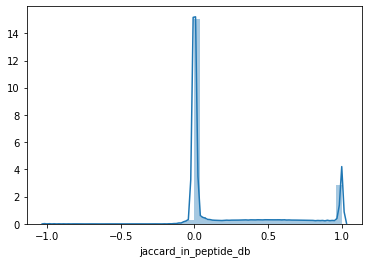

In [44]:
coding_scores.to_parquet(f'{pipeline_base_dir}/coding_scores.parquet')

In [1]:
pipeline_base_dir

NameError: name 'pipeline_base_dir' is not defined